In [16]:
!pip install rasterio

In [17]:
img_names = ["rainfall_raster_bound.tif", "ndvi_raster.tif", "clay_raster.tif", "PET_raster.tif", "elevation_raster.tif"]  # Add more as needed
#loc_var_names = ['lat','lon','Rain mm/y']
loc_var_names = ['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']
learning_rate=1e-3
weight_decay=1e-6
batch_size = 4096
epochs = 200

# Multi-Channel CNN with 2 branches

In [18]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point


# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


## Data pre-processing

In [19]:
# 1. Load Raster Images
def load_raster_data(filepaths):
    rasters = []
    for filepath in filepaths:
        with rasterio.open(filepath) as src:
            rasters.append(src.read(1))  # Load the first band
    return np.stack(rasters, axis=-1), src.transform

# Function to generate file paths for n raster images
def generate_raster_paths(base_path, img_names):
    return [os.path.join(base_path, img_name) for img_name in img_names]

# -----------------------------------------------------------------------
# Set the names of the input images!!
# -----------------------------------------------------------------------

# List of raster image filenames
data_paths = generate_raster_paths(os.path.join("./", "images_for_CNN"), img_names)
in_ims_stacked, transform = load_raster_data(data_paths)

# 2. Load the recharge rate data
clor = pd.read_csv(os.path.join("..", "data", "dat07_u.csv"))
quant = "Recharge RC 50% mm/y"

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])

# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


C:\Users\joept\AppData\Local\Temp\ipykernel_21176\4271265935.py:22: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv(os.path.join("..", "data", "dat07_u.csv"))


In [20]:

# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, in_ims_stacked, transform, size=32):
    rows, cols, num_layers = in_ims_stacked.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)

        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = in_ims_stacked[row-half_size:row+half_size, col-half_size:col+half_size, :]
            if img.shape == (size, size, num_layers):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size, num_layers)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size, num_layers)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, in_ims_stacked, transform)

Can be replaced with: Extract Sample-Centered Terrain Images WITH NORMALIZATION

def extract_sample_centered_images(clor_gdf, in_ims_stacked, transform, size=32):
    rows, cols, num_layers = in_ims_stacked.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = in_ims_stacked[row-half_size:row+half_size, col-half_size:col+half_size, :]
            if img.shape == (size, size, num_layers):
                # Normalize the image
                center_value = img[half_size, half_size, :]
                img = img - center_value  # Center the image
                img_std = img.std() if img.std() != 0 else 1  # Avoid division by zero
                img = img / img_std  # Scale by standard deviation
                terrain_images.append(img)
            else:
                # Partially out of bounds, normalize available portion
                center_value = img[img.shape[0]//2, img.shape[1]//2, :]
                img = img - center_value  # Center the image
                img_std = img.std() if img.std() != 0 else 1  # Avoid division by zero
                img = img / img_std  # Scale by standard deviation
                # Pad with zeros to make it (size, size, num_layers)
                padded_img = np.zeros((size, size, num_layers))
                padded_img[:img.shape[0], :img.shape[1], :] = img
                terrain_images.append(padded_img)
        else:
            terrain_images.append(np.zeros((size, size, num_layers)))  # Completely out of bounds

    return np.array(terrain_images)

imgs_ann = extract_sample_centered_images(clor_gdf, in_ims_stacked, transform)

In [21]:
for path in data_paths:
    with rasterio.open(path) as src:
        transform = src.transform
        pixel_width = transform[0]   # `a` value: pixel size in x-direction
        pixel_height = -transform[4] # `e` value (negated because it's typically negative)
        print(f"File: {path} - Pixel size: {pixel_width} x {pixel_height}")

File: ./images_for_CNN\rainfall_raster_bound.tif - Pixel size: 0.05 x 0.05
File: ./images_for_CNN\ndvi_raster.tif - Pixel size: 0.05 x 0.05
File: ./images_for_CNN\clay_raster.tif - Pixel size: 0.05 x 0.05
File: ./images_for_CNN\PET_raster.tif - Pixel size: 0.05 x 0.05
File: ./images_for_CNN\elevation_raster.tif - Pixel size: 0.05 x 0.05


#### Checking the centered images

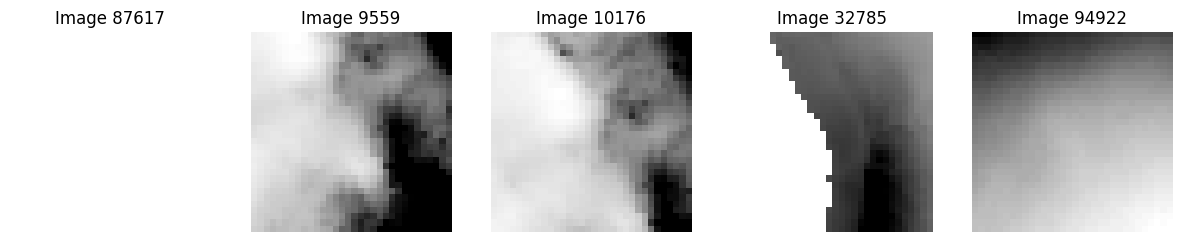

In [22]:
n = 5

# Select random images or specific indices
indices = np.random.choice(imgs_ann.shape[0], n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann[idx,:,:,0], cmap="binary")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [23]:
# -----------------------------------------------------------------------
# Select the same features in loc as the images selected in the cell above
# -----------------------------------------------------------------------
recharge_data = clor[['lat','lon','Rain mm/y', 'Recharge RC 50% mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]
loc = recharge_data[loc_var_names]
#loc = recharge_data[['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]

In [24]:
num_features = len(img_names)
if (loc.shape[1] - 2) != len(img_names):
    print('WARNING: THE FEATURE SIZES ARE DIFFERENT FOR THE TWO BRANCHES')

In [25]:
imagedim = 32

### Histograms of input data

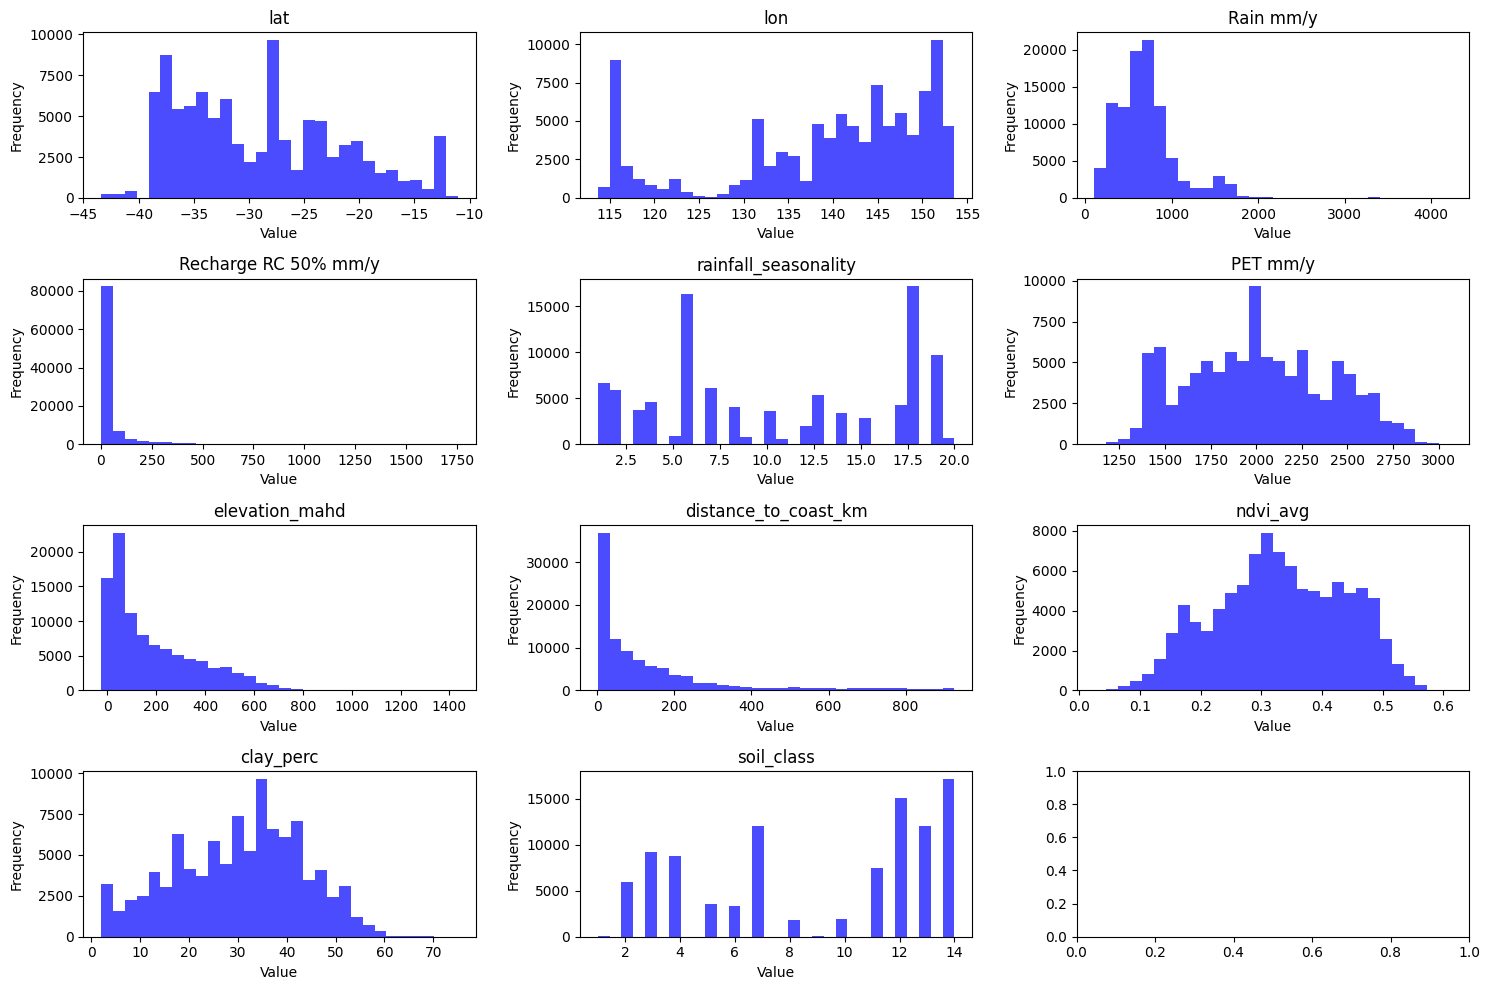

In [26]:
# Plot histograms for each column in recharge_data
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axs = axs.flatten()

for i, column in enumerate(recharge_data.columns):
    axs[i].hist(recharge_data[column].dropna(), bins=30, color='blue', alpha=0.7)
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Split data in train, val and test

In [27]:
# Split the data in 10 folds
np.random.seed(321)
fold_size = recharge_data.shape[0] // 10

# Shuffles the indices of the dataset
indices = np.arange(recharge_data.shape[0])
np.random.shuffle(indices)

# Split indices into test, validation, and train sets
test = indices[:fold_size]
val = indices[fold_size:2*fold_size]
train = indices[2*fold_size:]

x_train_imgs, x_train_loc = imgs_ann[train], loc.iloc[train].to_numpy()
x_val_imgs, x_val_loc = imgs_ann[val], loc.iloc[val].to_numpy()
x_test_imgs, x_test_loc = imgs_ann[test], loc.iloc[test].to_numpy()

# Take the log of the recharge rate to make the distribution less skewed and set as target
y_train = (recharge_data['Recharge RC 50% mm/y'].astype(float)[train])
y_val = (recharge_data['Recharge RC 50% mm/y'].astype(float)[val])
y_test = (recharge_data['Recharge RC 50% mm/y'].astype(float)[test])


### Normalize the data

In [28]:
class DataNormalizer:
    def __init__(self, train_data):
        # Calculate mean and standard deviation from training data
        self.mean = train_data.mean(axis=0)
        self.std = train_data.std(axis=0)

    def normalize(self, data):
        # Normalize data using the mean and std from the training data
        return (data - self.mean) / self.std

class MinMaxScaler:
    def __init__(self, train_data):
        # Calculate min and max from training data
        self.min = train_data.min(axis=0)
        self.max = train_data.max(axis=0)

    def normalize(self, data):
        # Normalize data using the min and max from the training data
        return (data - self.min) / (self.max - self.min)

# Create a normalizer using the training data
normalizer = MinMaxScaler(x_train_loc)

# Normalize the validation and test data using the same normalizer
x_train_loc_norm = normalizer.normalize(x_train_loc)
x_val_loc_norm = normalizer.normalize(x_val_loc)
x_test_loc_norm = normalizer.normalize(x_test_loc)

#normalizer_target = DataNormalizer.normalize(y_train)
#y_train = normalizer_target.normalize(ytrain)
#y_val = normalizer_target.normalize(y_val)
#y_test = normalizer_target.normalize(y_test)

In [29]:
# Normalize images
class UnitVarianceScaler_imgs:
    def __init__(self, train_data):
        # Reshape to (num_images * image_size * image_size * num_channels)
        train_data_reshaped = train_data.reshape(-1, train_data.shape[-1])
        # Calculate mean and standard deviation from training data across all channels
        self.mean = train_data_reshaped.mean(axis=0)
        self.std = train_data_reshaped.std(axis=0)

    def normalize(self, data):
        # Reshape data for normalization
        data_reshaped = data.reshape(-1, data.shape[-1])

        # Normalize data using the mean and std from the training data
        normalized_data = (data_reshaped - self.mean) / self.std

        return normalized_data.reshape(data.shape)

class MinMaxScaler_imgs:
    def __init__(self, train_data):
        # Reshape to (num_images * image_size * image_size * num_channels)
        train_data_reshaped = train_data.reshape(-1, train_data.shape[-1])

        # Calculate min and max from training data across all channels
        self.min = train_data_reshaped.min(axis=0)
        self.max = train_data_reshaped.max(axis=0)

    def normalize(self, data):
        # Reshape data for normalization
        data_reshaped = data.reshape(-1, data.shape[-1])

        # Add a small epsilon to avoid division by zero
        epsilon = 1e-10
        normalized_data = (data_reshaped - self.min) / (self.max - self.min + epsilon)

        # Reshape back to original shape
        return normalized_data.reshape(data.shape)


normalizer_imgs = MinMaxScaler_imgs(x_train_imgs)

# Normalize the validation and test data using the same normalizer
x_train_imgs_norm = normalizer_imgs.normalize(x_train_imgs)
x_val_imgs_norm = normalizer_imgs.normalize(x_val_imgs)
x_test_imgs_norm = normalizer_imgs.normalize(x_test_imgs)

In [30]:
x_train = [x_train_imgs_norm, x_train_loc_norm]
x_val = [x_val_imgs_norm, x_val_loc_norm]
x_test = [x_test_imgs_norm, x_test_loc_norm]

# Reshape the image data
x_train[0] = x_train[0].reshape((x_train[0].shape[0], imagedim, imagedim, num_features))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], imagedim, imagedim, num_features))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], imagedim, imagedim, num_features))

## Model Definition

In [31]:
# Use neural network to learn relationship between terrain features and geochemistry ####
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp

In [32]:

# We assume that the number of features is the same in both branches
input_features = len(img_names)
input_loc_features = len(loc_var_names)
imagedim = 32

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, input_features), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(input_loc_features,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)

main_output = Dense(units=1, activation="linear", name="output", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output) #singe value in the output

#main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
#main_output = tf.keras.layers.Lambda(          #multiple output values
#    lambda x: tf.concat([x[:, 0:1], tf.math.softplus(x[:, 1:2])], axis=1)
#)(main_output)

# Define model inputs
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input],
    outputs=main_output
)

# Define the negative log-likelihood function
def negloglik(y_true, y_pred):
    # Assuming y_pred is a distribution, e.g., Normal distribution
    dist = tfd.Normal(loc=y_pred[:, 0], scale=tf.math.softplus(y_pred[:, 1]))
    return -tf.reduce_mean(dist.log_prob(y_true))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=weight_decay),
            loss='mean_squared_error')

# Summary of the model
model.summary()

c:\Users\joept\miniconda3\envs\tf\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input (InputLayer)        [(None, 32, 32, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 128)  5888        ['conv_input[0][0]']             
                                                                                                  
 activation (Activation)        (None, 10, 10, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 10, 10, 128)  0          ['activation[0][0]']             
 out2D)                                                                                       

In [33]:
#class for saving the best weights
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

save_best_model = SaveBestModel()

# Running the model

In [34]:
#from tensorflow.keras.callbacks import ModelCheckpoint

# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = batch_size
epochs = epochs
epochs = 500

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2,
    callbacks=[save_best_model]
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)


Epoch 1/500
20/20 - 29s - loss: 8303.1572 - val_loss: 5307.4512 - 29s/epoch - 1s/step
Epoch 2/500
20/20 - 3s - loss: 4672.4263 - val_loss: 3926.7720 - 3s/epoch - 146ms/step
Epoch 3/500
20/20 - 3s - loss: 3961.7134 - val_loss: 3716.4399 - 3s/epoch - 158ms/step
Epoch 4/500
20/20 - 3s - loss: 3832.0354 - val_loss: 3691.5024 - 3s/epoch - 150ms/step
Epoch 5/500
20/20 - 3s - loss: 3725.8157 - val_loss: 3594.3689 - 3s/epoch - 157ms/step
Epoch 6/500
20/20 - 3s - loss: 3673.1545 - val_loss: 3589.5593 - 3s/epoch - 146ms/step
Epoch 7/500
20/20 - 3s - loss: 3642.2522 - val_loss: 3548.1089 - 3s/epoch - 143ms/step
Epoch 8/500
20/20 - 3s - loss: 3646.6277 - val_loss: 3705.9595 - 3s/epoch - 136ms/step
Epoch 9/500
20/20 - 3s - loss: 3621.2786 - val_loss: 3506.8191 - 3s/epoch - 137ms/step
Epoch 10/500
20/20 - 3s - loss: 3593.9165 - val_loss: 3704.7107 - 3s/epoch - 139ms/step
Epoch 11/500
20/20 - 3s - loss: 3665.0315 - val_loss: 3499.4583 - 3s/epoch - 136ms/step
Epoch 12/500
20/20 - 3s - loss: 3565.5225 

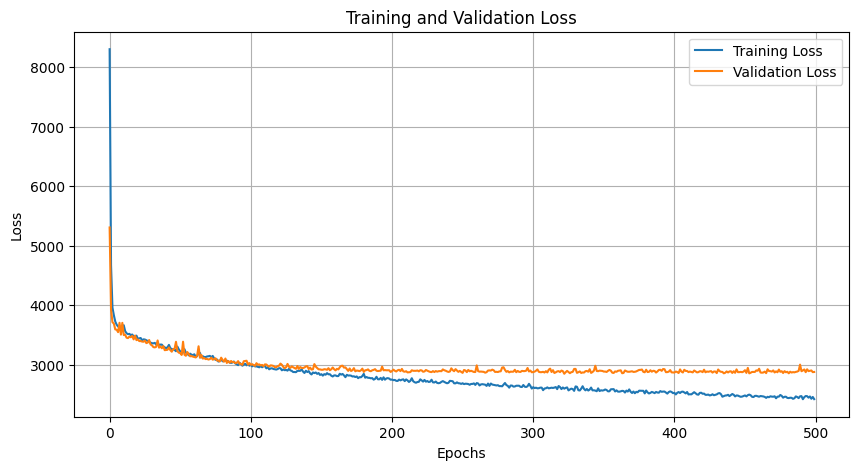

In [35]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ... existing code ...

In [36]:
# loading weights of best epoch
model.set_weights(save_best_model.best_weights)
# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': model.predict(x_test)[:, 0]})

from sklearn.metrics import r2_score

# Calculate and print R squared and RMSE
print(f"R squared = {round(r2_score(holdout['obs'], holdout['preds']), 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")

308/308 [==============================] - 1s 2ms/step
R squared = 0.721
RMSE = 55.13


In [37]:
# Assuming 'model' is your trained Keras model
model.save_weights('model_weights.weights.h5')

In [38]:
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss at Best Epoch: {history.history['val_loss'][best_epoch]}")
r2 = r2_score(holdout['obs'], holdout['preds'])
print(f"R squared: {r2}")

# Calculate R2 of best epoch
model.set_weights(save_best_model.best_weights)
best_epoch_preds = model.predict(x_val)
best_epoch_r2 = r2_score(y_val, best_epoch_preds)
print(f"R squared at Best Epoch: {best_epoch_r2}")

Best Epoch: 322
Validation Loss at Best Epoch: 2849.388916015625
R squared: 0.7208852943399828
308/308 [==============================] - 1s 4ms/step
R squared at Best Epoch: 0.7068509717506845
